<a href="https://colab.research.google.com/github/Unfeir/DS/blob/main/HW_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import losses
from keras import metrics
from keras import models
from keras import optimizers
from sklearn.model_selection import train_test_split

from PIL import Image

# Частина 1
В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу. Підберіть архітектуру мережі та навчіть її на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.


https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data

In [4]:
lr = 0.0000001
n_epochs = 30
batch_size = 32
num_classes = 10

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [6]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.x_data))

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_x = self.x_data[start_idx:end_idx]
        batch_y = self.y_data[start_idx:end_idx]

        processed_batch_x = [self.preprocess_image(image) for image in batch_x]
        return np.array(processed_batch_x), batch_y

    def preprocess_image(self, image):
        image = Image.fromarray(image)
        image = image.resize((150, 150))
        image = img_to_array(image)
        image = preprocess_input(image)
        return image

In [9]:
tf.config.run_functions_eagerly(True)

In [9]:
model = models.Sequential([
                           layers.Conv2D(
                                         32,
                                         (3, 3,),
                                         activation='relu',
                                         padding='same',
                                         input_shape = (28, 28, 1)
                                         ),
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(
                                         64,
                                         (3, 3),
                                         activation='relu'
                                         ),
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(
                                         64,
                                         (3, 3),
                                         activation='relu'
                                         ),

                           layers.Flatten(),
                           layers.Dense(
                                        32,
                                        activation='relu'
                                        ),

                           layers.Dense(
                                        10,
                                        activation='softmax'
                                        )
                           ])



In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [11]:
model.compile(
              optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

callback_early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    verbose=1,
    mode="max",
)

callback_save = ModelCheckpoint(
    "best.hdf5",
    monitor="val_loss",
    save_best_only=True,
)

In [11]:
y_train_enc = keras.utils.to_categorical(y_train, num_classes)
y_test_enc = keras.utils.to_categorical(y_test, num_classes)
y_train_enc.shape,  y_test_enc.shape

((60000, 10), (10000, 10))

In [13]:
history = model.fit(x_train,
          y_train_enc,
          epochs=n_epochs,
          batch_size=batch_size,
          validation_data=(x_test, y_test_enc),
          verbose=1,
          callbacks=[callback_early_stopping, callback_save])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
1875/1875 [==============================] - 138s 69ms/step - loss: 0.4782 - accuracy: 0.8260 - val_loss: 0.3516 - val_accuracy: 0.8684
Epoch 2/30
1875/1875 [==============================] - 104s 55ms/step - loss: 0.3041 - accuracy: 0.8892 - val_loss: 0.2985 - val_accuracy: 0.8904
Epoch 3/30
1875/1875 [==============================] - 107s 57ms/step - loss: 0.2583 - accuracy: 0.9062 - val_loss: 0.2690 - val_accuracy: 0.9022
Epoch 4/30
1875/1875 [==============================] - 105s 56ms/step - loss: 0.2279 - accuracy: 0.9165 - val_loss: 0.2774 - val_accuracy: 0.9007
Epoch 5/30
1875/1875 [==============================] - 103s 55ms/step - loss: 0.2043 - accuracy: 0.9245 - val_loss: 0.2762 - val_accuracy: 0.8992
Epoch 5: early stopping


In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test_enc)

313/313 [==============================] - 7s 23ms/step - loss: 0.2762 - accuracy: 0.8992


In [15]:
model_2 = models.Sequential([
                           layers.Conv2D(
                                         32,
                                         (3, 3,),
                                         activation='relu',
                                         padding='same',
                                         input_shape = (28, 28, 1)
                                         ),
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(
                                         64,
                                         (3, 3),
                                          padding='same',
                                         activation='relu'
                                         ),
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(
                                         128,
                                         (3, 3),
                                         padding='same',
                                         activation='relu'
                                         ),
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(
                                         256,
                                         (3, 3),
                                         padding='same',
                                         activation='relu'
                                         ),
                           layers.MaxPooling2D((2, 2)),

                           layers.Flatten(),
                           layers.Dense(
                                        32,
                                        activation='relu'
                                        ),

                           layers.Dense(
                                        10,
                                        activation='softmax'
                                        )
                           ])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 128)       

In [16]:
model_2.compile(
              optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

callback_early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    verbose=1,
    mode="max",
)

callback_save = ModelCheckpoint(
    "best_2.hdf5",
    monitor="val_loss",
    save_best_only=True,
)

In [17]:
history_2 = model_2.fit(x_train,
          y_train_enc,
          epochs=n_epochs,
          batch_size=batch_size,
          validation_data=(x_test, y_test_enc),
          verbose=1,
          callbacks=[callback_early_stopping, callback_save])

Epoch 1/30
1875/1875 [==============================] - 122s 65ms/step - loss: 0.4570 - accuracy: 0.8335 - val_loss: 0.3268 - val_accuracy: 0.8838
Epoch 2/30
1875/1875 [==============================] - 118s 63ms/step - loss: 0.2882 - accuracy: 0.8949 - val_loss: 0.2818 - val_accuracy: 0.8984
Epoch 3/30
1875/1875 [==============================] - 119s 64ms/step - loss: 0.2405 - accuracy: 0.9120 - val_loss: 0.2882 - val_accuracy: 0.8970
Epoch 4/30
1875/1875 [==============================] - 119s 63ms/step - loss: 0.2092 - accuracy: 0.9224 - val_loss: 0.2543 - val_accuracy: 0.9072
Epoch 5/30
1875/1875 [==============================] - 119s 64ms/step - loss: 0.1841 - accuracy: 0.9323 - val_loss: 0.2388 - val_accuracy: 0.9145
Epoch 6/30
1875/1875 [==============================] - 119s 64ms/step - loss: 0.1610 - accuracy: 0.9403 - val_loss: 0.2394 - val_accuracy: 0.9198
Epoch 7/30
1875/1875 [==============================] - 119s 63ms/step - loss: 0.1421 - accuracy: 0.9478 - val_loss: 0

In [18]:
test_loss_2, test_acc_2 = model_2.evaluate(x_test, y_test_enc)

313/313 [==============================] - 9s 29ms/step - loss: 0.2859 - accuracy: 0.9157


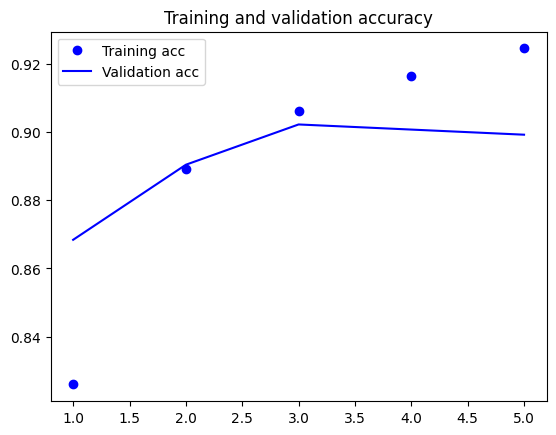

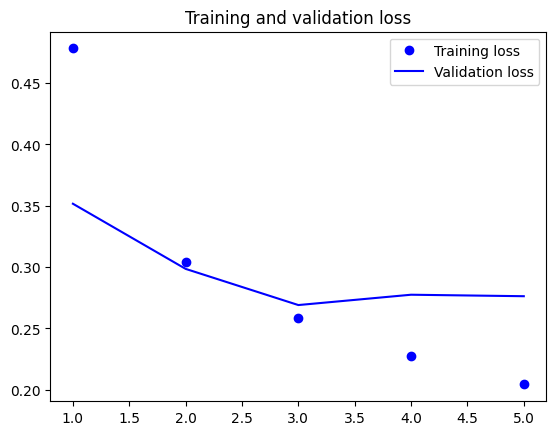

In [19]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

<ipython-input-20-c96ca95cf626>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc_2, "bo", color='red', label="Training acc")
<ipython-input-20-c96ca95cf626>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc_2, "b", color='red', label="Validation acc")
<ipython-input-20-c96ca95cf626>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss_2, "bo", color='red', label="Training loss")
<ipython-input-20-c96ca95cf626>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take preced

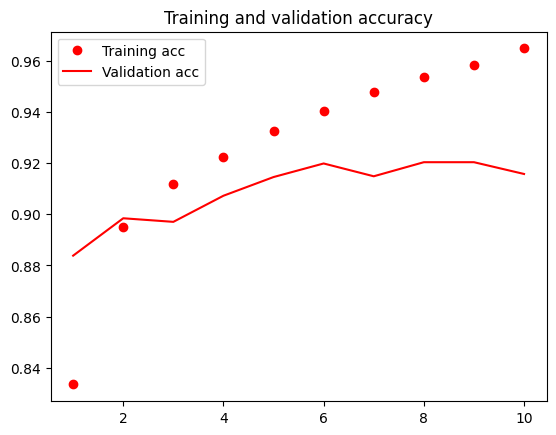

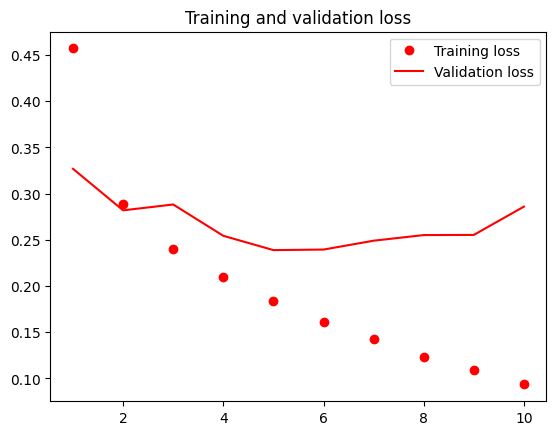

In [20]:
acc_2 = history_2.history["accuracy"]
val_acc_2 = history_2.history["val_accuracy"]
loss_2 = history_2.history["loss"]
val_loss_2 = history_2.history["val_loss"]

epochs = range(1, len(acc_2) + 1)

plt.plot(epochs, acc_2, "bo", color='red', label="Training acc")
plt.plot(epochs, val_acc_2, "b", color='red', label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss_2, "bo", color='red', label="Training loss")
plt.plot(epochs, val_loss_2, "b", color='red', label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

Перша модель loss: 0.2043 - accuracy: 0.9245 - val_loss: 0.2762 - val_accuracy: 0.8992

Друга модель loss: 0.0934 - accuracy: 0.9647 - val_loss: 0.2859 - val_accuracy: 0.9157

Ускладнення моделі показало дещо кращі показники при валідації. але всеодно обидві піддались перенавчанню. Треба пробувати накладати фільтри на зобрадення для покращення результатів




# Частина 2
В цій частині ми знову будемо працювати з датасетом fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.

Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.

Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

In [12]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)
x_train_rgb = np.stack([x_train] * 3, axis=-1)
x_test_rgb = np.stack([x_test] * 3, axis=-1)


train_generator = DataGenerator(x_train_rgb, y_train_enc, batch_size)
test_generator = DataGenerator(x_test_rgb, y_test_enc, batch_size)
train_generator[0][0].shape

(32, 150, 150, 3)

In [22]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False
flatten_layer = Flatten()(base_model.output)
dense_layer = Dense(256, activation='relu')(flatten_layer)
output_layer = Dense(num_classes, activation='softmax')(dense_layer)
model_3 = Model(inputs=base_model.input, outputs=output_layer)

model_3.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [23]:
model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


callback_early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    verbose=1,
    mode="max",
)

callback_save = ModelCheckpoint(
    "best_3.hdf5",
    monitor="val_loss",
    save_best_only=True,
)

In [24]:
history_3 = model_3.fit(train_generator,
                    epochs=n_epochs,
                    verbose=1,
                    validation_data=test_generator,
                    callbacks=[callback_early_stopping, callback_save])

Epoch 1/30
1875/1875 [==============================] - 586s 308ms/step - loss: 0.5084 - accuracy: 0.8744 - val_loss: 0.3252 - val_accuracy: 0.8863
Epoch 2/30
1875/1875 [==============================] - 576s 307ms/step - loss: 0.2395 - accuracy: 0.9143 - val_loss: 0.2874 - val_accuracy: 0.9029
Epoch 3/30
1875/1875 [==============================] - 577s 308ms/step - loss: 0.2081 - accuracy: 0.9265 - val_loss: 0.3087 - val_accuracy: 0.9025
Epoch 4/30
1875/1875 [==============================] - 575s 307ms/step - loss: 0.1776 - accuracy: 0.9379 - val_loss: 0.3449 - val_accuracy: 0.9018
Epoch 4: early stopping


In [25]:
test_loss_3, test_acc_3 = model_3.evaluate(test_generator)

313/313 [==============================] - 33s 106ms/step - loss: 0.3449 - accuracy: 0.9018


<ipython-input-26-9d4263ba2b81>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc_3, "bo", color='black', label="Training acc")
<ipython-input-26-9d4263ba2b81>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc_3, "b", color='black', label="Validation acc")
<ipython-input-26-9d4263ba2b81>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss_3, "bo", color='black', label="Training loss")
<ipython-input-26-9d4263ba2b81>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take 

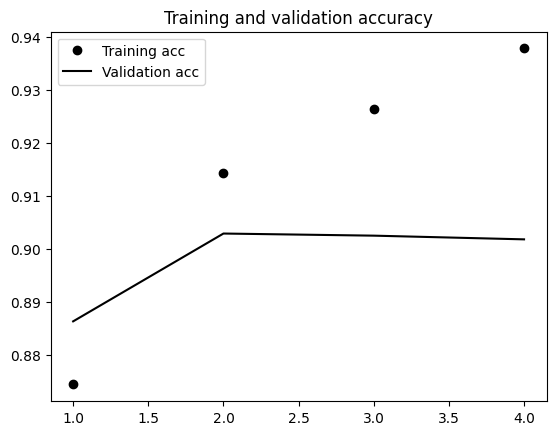

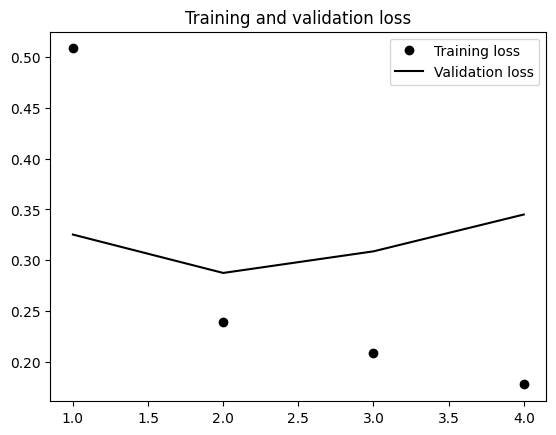

In [26]:
acc_3 = history_3.history["accuracy"]
val_acc_3 = history_3.history["val_accuracy"]
loss_3 = history_3.history["loss"]
val_loss_3 = history_3.history["val_loss"]

epochs = range(1, len(acc_3) + 1)

plt.plot(epochs, acc_3, "bo", color='black', label="Training acc")
plt.plot(epochs, val_acc_3, "b", color='black', label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss_3, "bo", color='black', label="Training loss")
plt.plot(epochs, val_loss_3, "b", color='black', label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

loss: 0.1776 - accuracy: 0.9379 - val_loss: 0.3449 - val_accuracy: 0.9018

третя моель недивлячись на складність теж не дала суттєвого покращення
